# Experiments

In [1]:
import numpy as np
import math
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import os
from data.load_data import load_monk, load_MLCup
from src.MetricFunctions import get_metric_instance
from src.MLP import MLP
from src.GridSearch import GridSearch, RandomGridsearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.EarlyStopping import EarlyStopping
from src.BestModelSearch import BestModelSearch
from tqdm import tqdm

## Task 1: Regression

Preparation: Loading MLCup Dataset

In [ ]:
path = os.getcwd()
file_train = '/data/ML-CUP22-TR.csv'
file_test = '/data/ML-CUP22-TS.csv'

labels_train = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y1','y2']
labels_test = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']

X_train, y_train = load_MLCup(path + file_train, labels_train)
X_test = load_MLCup(path + file_test, labels_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)



In [ ]:
fig, ax = plt.subplots()
for step in [0.02,0.03,0.04,0.05]:
    mlp = MLP([60,40,20], 9, 2, task = "regression", activation_function = 'sigm')
    mlp.fit(X_train, y_train, n_epochs = 500, batch_size = 256, momentum = 0.8, Nesterov = False, step = step, patience = 1000)
    ax.plot(mlp.validation_curve, label = str(step))
    print(mlp.validation_curve[499])
ax.legend()

In [ ]:
for alpha_l2 in [0,0.05]:
    mlp = MLP([60,20], 9, 2, task = "regression", activation_function = 'sigm')
    mlp.fit(X_train, y_train, n_epochs = 500, batch_size = 256, step = 0.02, 
            momentum = 0.8, Nesterov = True, patience = 1000, regularization = "l2", alpha_l2=alpha_l2)
    fig, ax = plt.subplots()
    ax.plot(mlp.learning_curve, label = "training MSE")
    ax.plot(mlp.validation_curve, label = "validation MSE")
    ax.legend()
    print(mlp.validation_curve[499])

## Task 2: Classification

### Preparation: Loading Monk Datasets

In [2]:
path = os.getcwd()
file_train = '/data/monks-1.train'

labels = ['class','x1','x2','x3','x4','x5','x6']
tanh_labels = True
TR_sets = [[]] 
TS_sets = [[]] 


for i in range(1,4):
    TR = load_monk(path + f'/data/monks-{i}.train', labels)
    TS = load_monk(path + f'/data/monks-{i}.test', labels)
    if tanh_labels:
        for j in range(len(TS[1])):
            if int(TS[1][j]) == 0:
                TS[1][j] = -1

        for j in range(len(TR[1])):
            if int(TR[1][j]) == 0:
                TR[1][j] = -1
    TR_sets.append(TR)
    TS_sets.append(TS)

print(TS_sets[1][1][0])
print(TS_sets[2][1][0])
print(TS_sets[3][1][0])



[1.]
[-1.]
[1.]


### Experiment 2.1 - Random Runs with Tanh output

100%|██████████| 1/1 [00:17<00:00, 17.48s/it]

Combination [0.3 0.5 2.  0. ]: 1.0 1.0 0.988 0.983

New best value: 0.9929904941924173! With [0.3 0.5 2.  0. ]



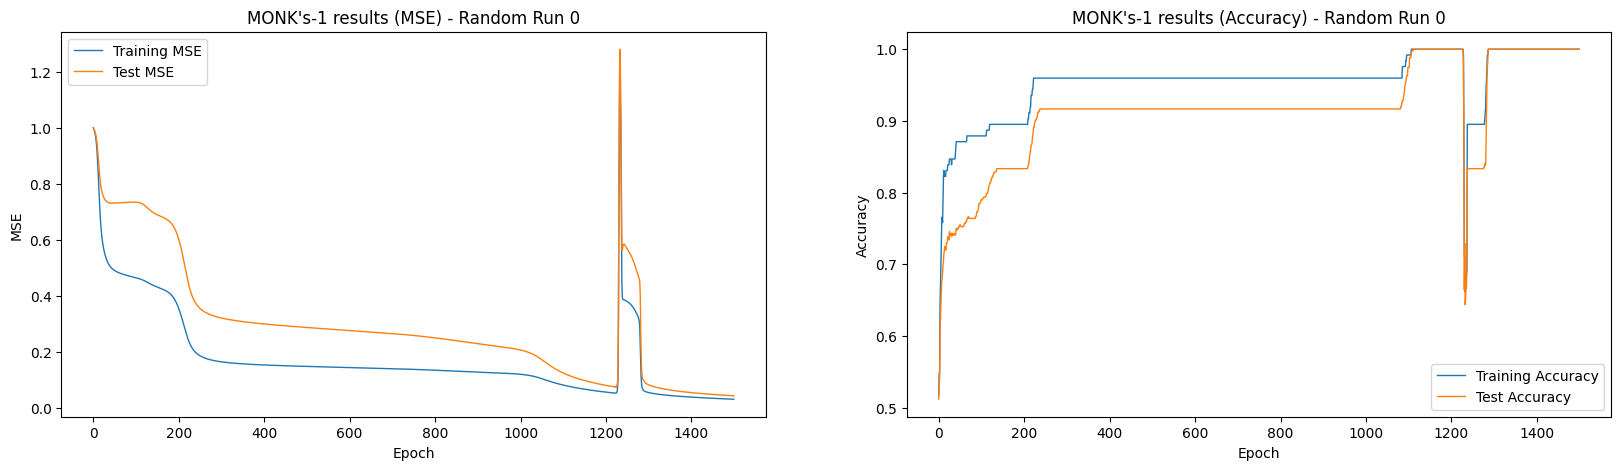

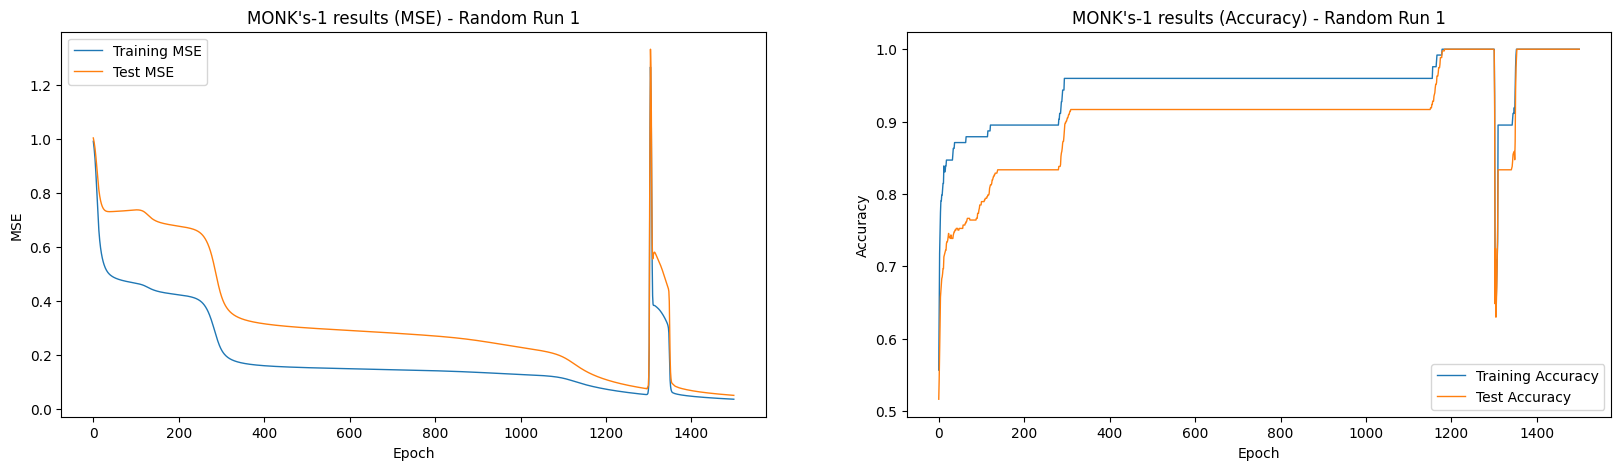

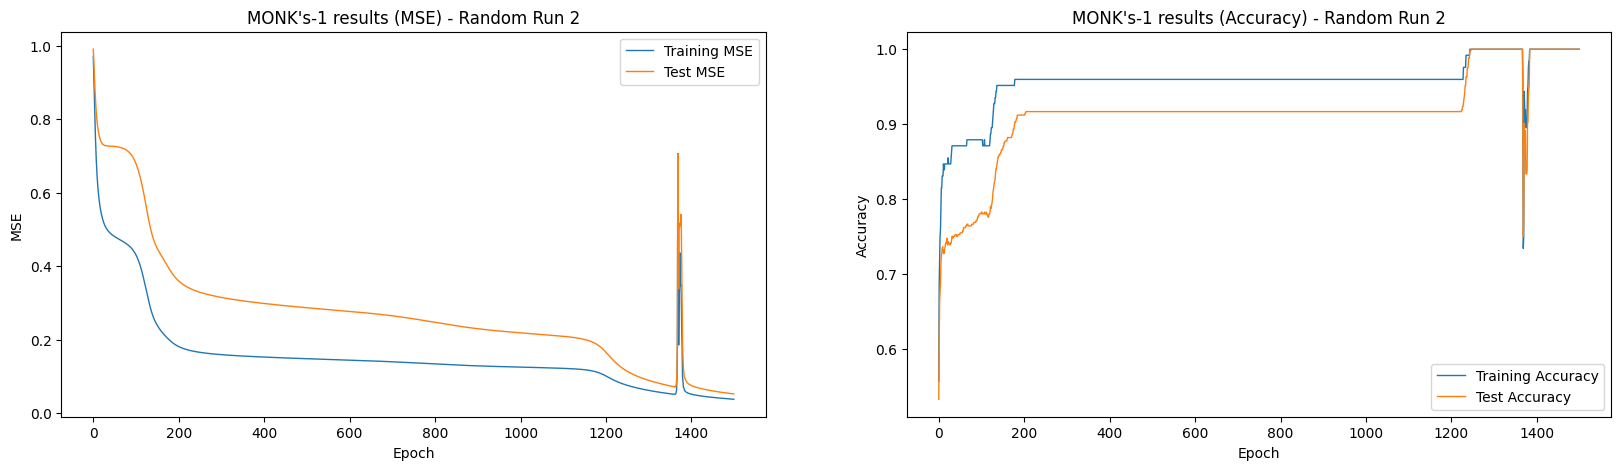

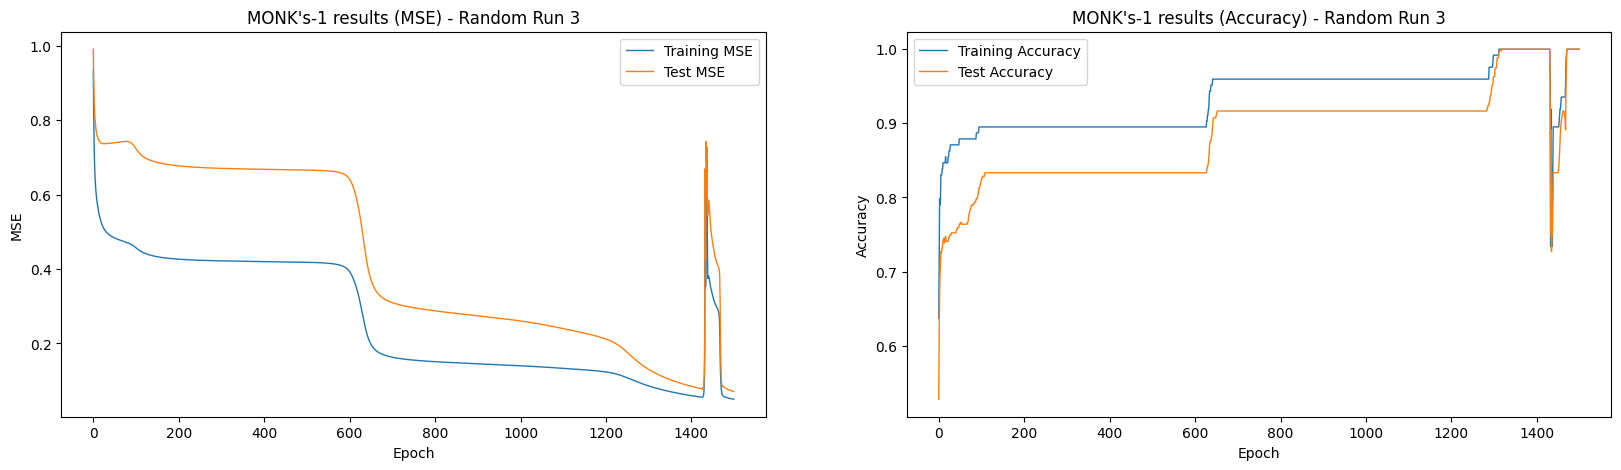

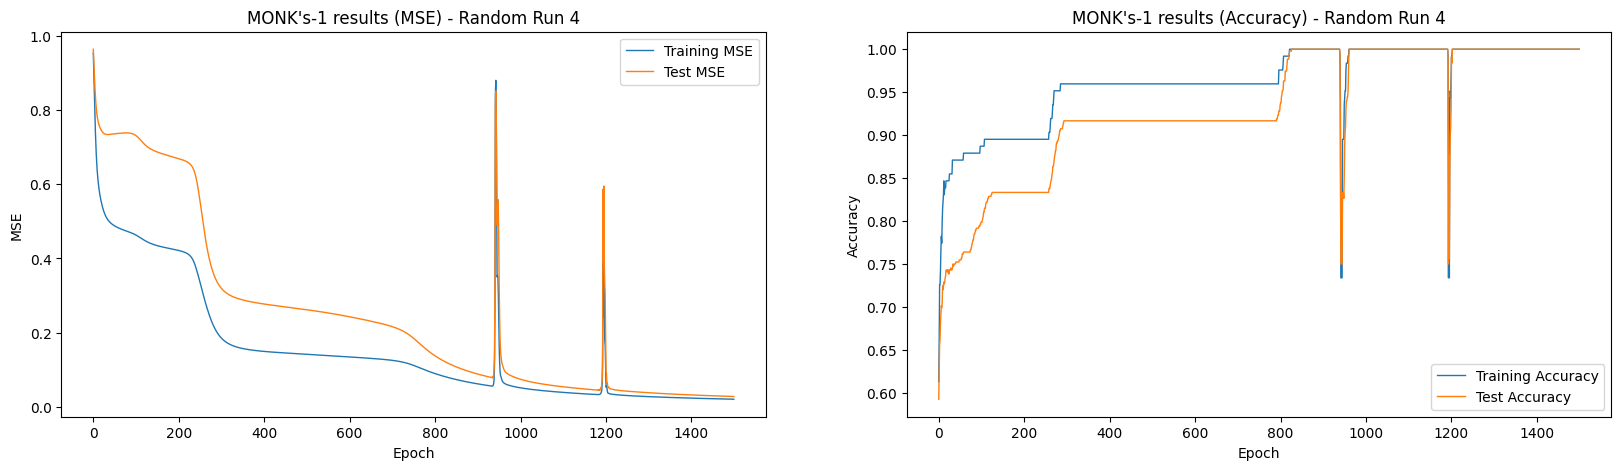

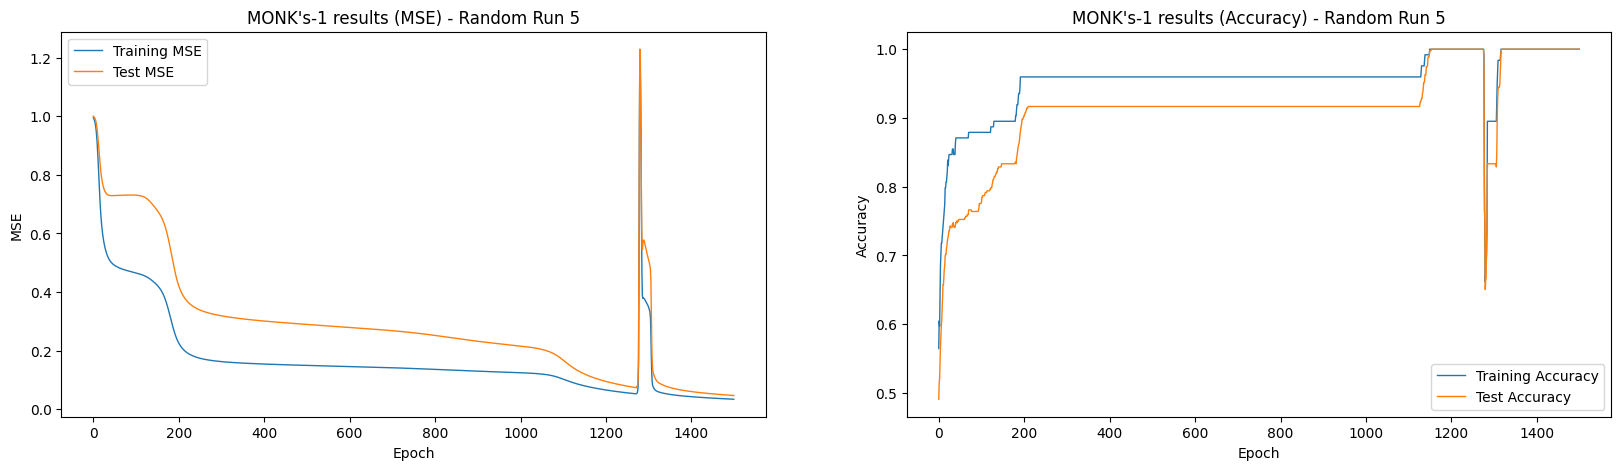

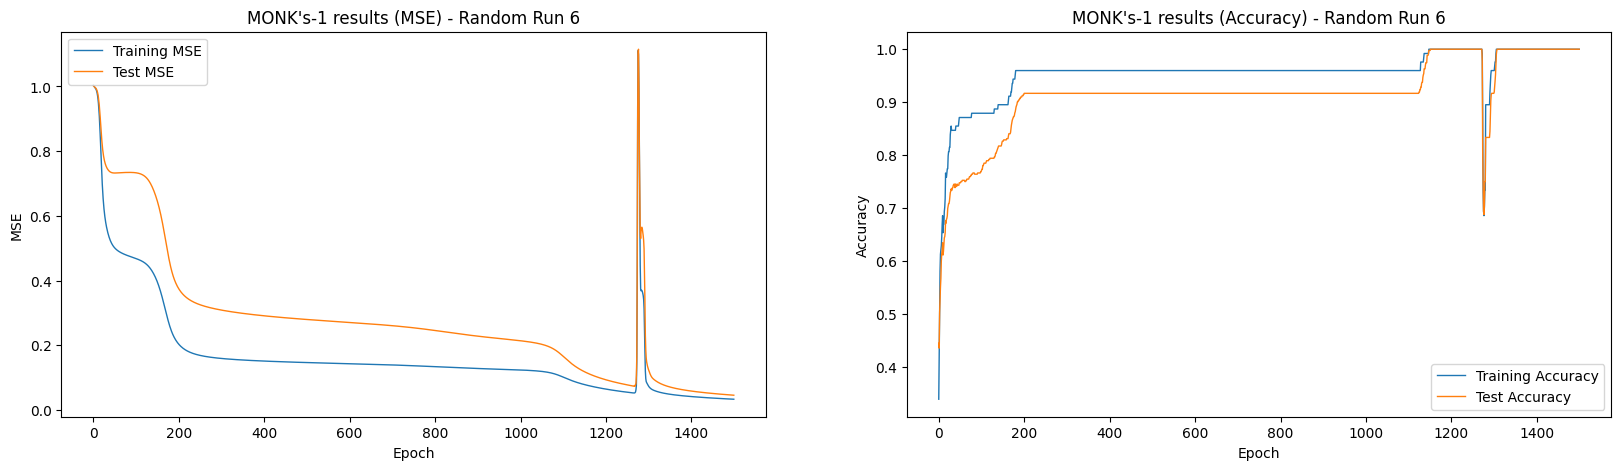

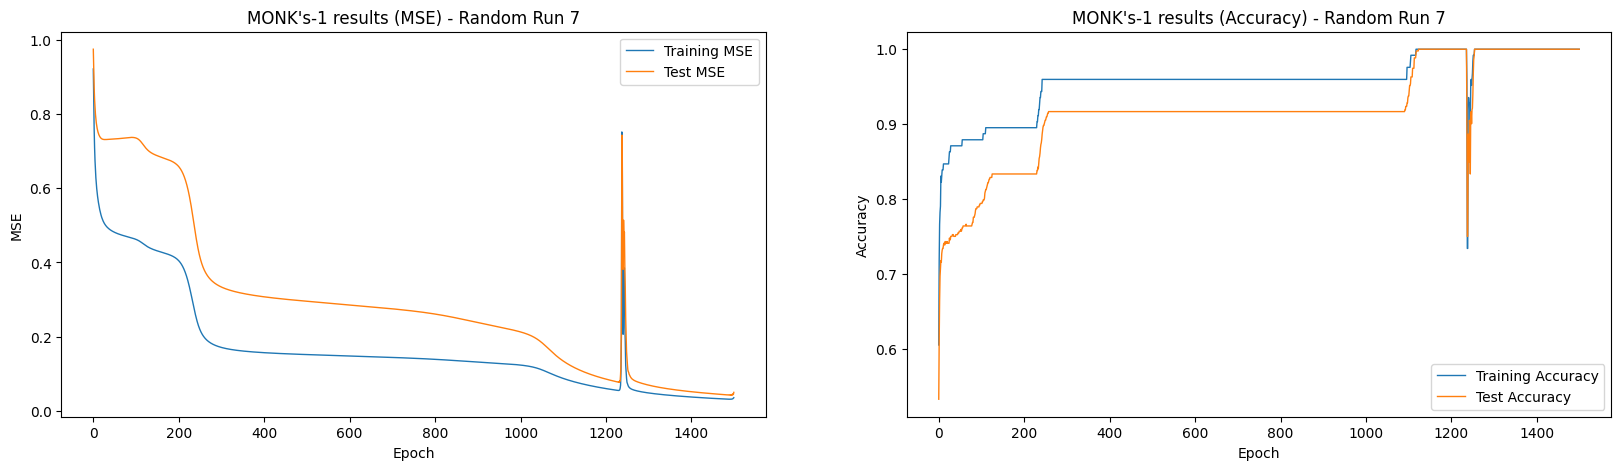

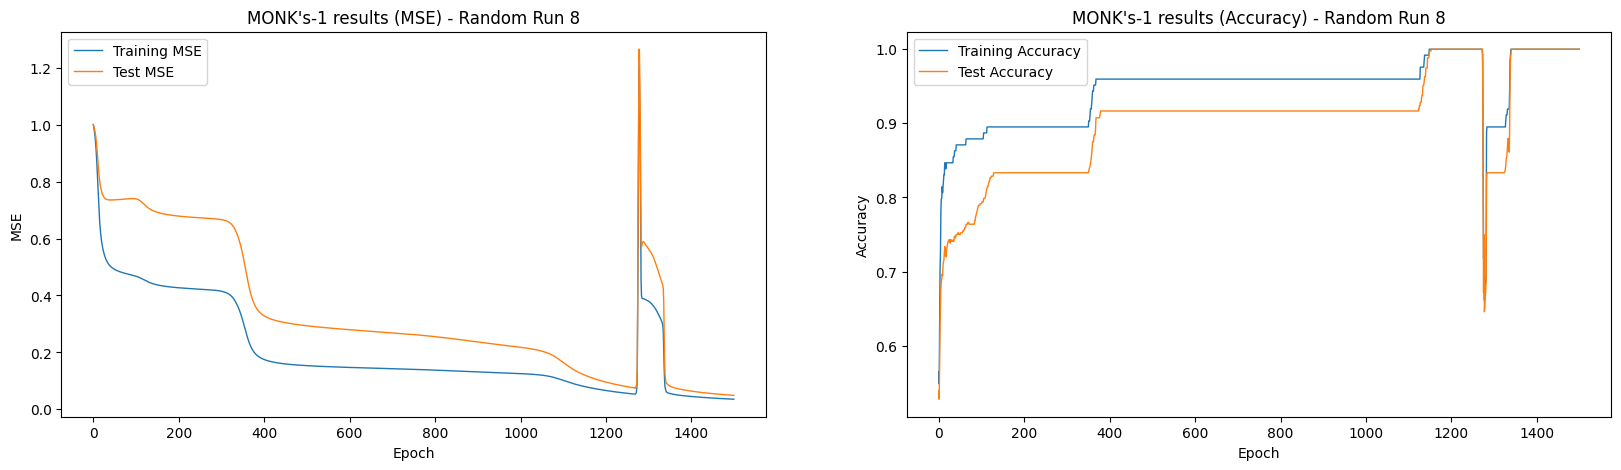

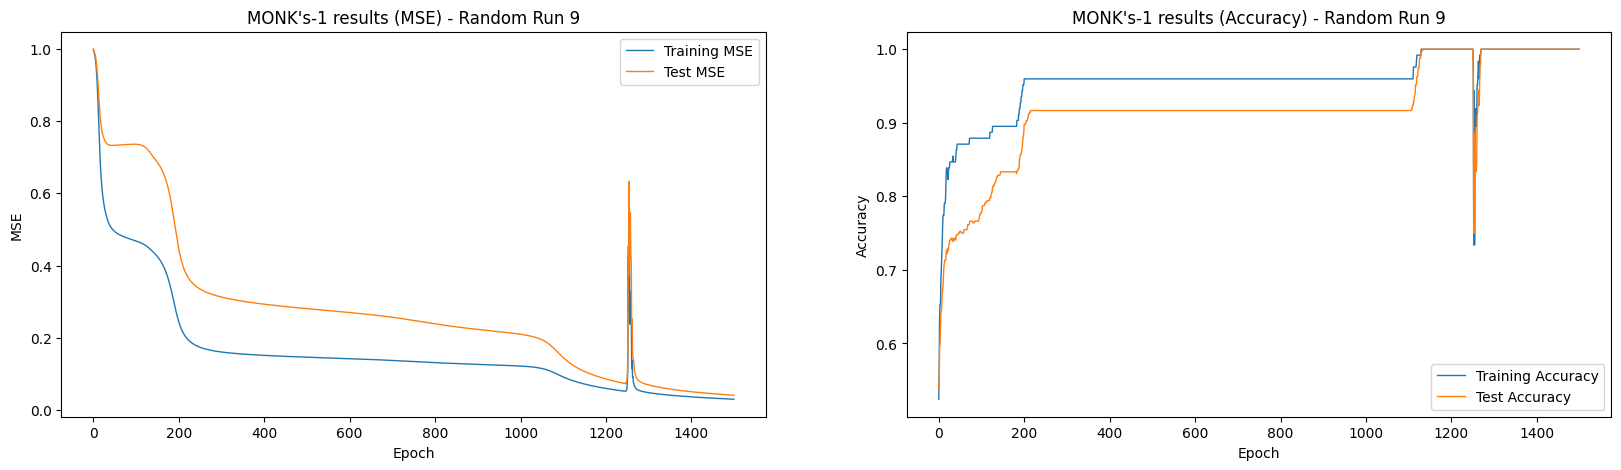

In [4]:
path = os.getcwd() + '/results/MonkResultsAll.txt'
path1 = os.getcwd() + '/results/Combinations.txt'
curves = []
params = {
    "n_epochs" : 1500, 
    "error" : "mse", 
    "verbose" : False,
    # "step" : 0.45, 
    # "momentum" : 0.6,
    # 'weights_scale' : 0.0005,
    "weights_initialization" : 'xavier',
    "early_stopping" : False,
    "eval_metric" : 'mse'
    }
super_verbose = False
verbose = True
best_value = 0

seed = 0
step =  (0.3)
momentum = (0.5)
weights_scale = (0)
# step = np.linspace(0.4, 0.8, 10)
# momentum = np.linspace(0.5, 0.6, 2)
n_units = (2)

combinations = np.array(np.meshgrid(step, momentum, n_units, weights_scale)).T.reshape(-1, 4)

with open(path1, 'w') as combfile:
    combfile.write(str(combinations))

# Statistics of all random runs
MSE_TR = np.zeros((10, 4))
MSE_TS = np.zeros((10, 4))
ACC_TR = np.zeros((10, 4))
ACC_TS = np.zeros((10, 4))

def name(i):
    if i in (0,1,2):
        return i + 1
    else:
        return i

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

with open(path, 'w') as result_file:

    for combination in tqdm(range(len(combinations))):
        params["step"] = combinations[combination][0]
        params["momentum"] = combinations[combination][1]
        params['weights_scale'] = combinations[combination][3]

        for k in range(10):
            
            curves = []
            if super_verbose == True:
                print("**************************************")
                print(f"Random Run {k + 1}\n")
            
            if verbose == True:
                result_file.write("**************************************\n")
                result_file.write(f"Random run {k + 1}" + '\n')

            for i in range(0,4):

                if super_verbose == True:
                    print(f"Monk Dataset {name(i)}")
                
                input_size = TR_sets[name(i)][0][0].shape[0]
                n_samples = TR_sets[name(i)][0].shape[0]
                params["batch_size"] = n_samples
                
                mlp = MLP([int(combinations[combination][2])], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh', random_seed = k + seed)

                # Curves with MSE/Accuracy
                if i < 3:
                    # All without regularization
                    params["regularization"] = 'no'
                    # params["regularization"] = 'l2'
                    # params["alpha_l2"] = 0.0075
                    mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
                else:
                    # Monk 3 with regularization
                    params["regularization"] = 'l2'
                    params["alpha_l2"] = 0.0075
                    mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
                
                curves.append([[mlp.learning_curve, mlp.learning_accuracy_curve], [mlp.validation_curve, mlp.test_accuracy_curve]])
                
                MSE_TR[k, i] = mlp.learning_curve[-1]
                MSE_TS[k, i] = mlp.validation_curve[-1]
                ACC_TR[k, i] = mlp.learning_accuracy_curve[-1]
                ACC_TS[k, i] = mlp.test_accuracy_curve[-1]

                if super_verbose == True:
                    print(f"Accuracy on test set {name(i)}, Random Run {k + 1}: {mlp.evaluate_model(TS_sets[name(i)][0], TS_sets[name(i)][1], metric = 'accuracy')}")
                    print()       
                
                if i < 3:
                    result_file.write(f"Results on MONK's {i + 1}: \n")
                else: 
                    result_file.write(f"Results on MONK's {i} with regularization: \n")
                
                result_file.write("MSE: \tTR: " + str(MSE_TR[k, i]) + "\tTS: " + str(MSE_TS[k, i]) + '\n')
                result_file.write("ACC: \tTR: " + str(ACC_TR[k, i]) + "\tTS: " + str(ACC_TS[k, i]) + '\n')
                result_file.write('\n')

                weights = [layer.get_params() for layer in mlp.layers]
                result_file.write(f"Weights {weights} ")
    

            # Plot the learning curves
            figure, axis = plt.subplots(1, 2, figsize = (20, 5))

            for j in range(1):

                # Plot MSE training and validation curves
                axis[0].plot(range(0, len(curves[j][0][0]), 1), curves[j][0][0],\
                    linewidth = 1, label = 'Training MSE')
                axis[0].plot(range(0, len(curves[j][1][0]), 1), curves[j][1][0],\
                    linewidth = 1, label = 'Test MSE')
                axis[0].set_title(f"MONK's-{name(j)} results (MSE) - Random Run {k}")
                axis[0].set_xlabel('Epoch') 
                axis[0].set_ylabel('MSE')  
                axis[0].legend()


                # Plot Accuracy training and validation curves
                axis[1].plot(range(0, len(curves[j][0][1]), 1), curves[j][0][1],\
                    linewidth = 1, label = 'Training Accuracy')
                axis[1].plot(range(0, len(curves[j][1][1]), 1), curves[j][1][1],\
                    linewidth = 1, label = 'Test Accuracy')
                axis[1].set_title(f"MONK's-{name(j)} results (Accuracy) - Random Run {k}")
                axis[1].set_xlabel('Epoch') 
                axis[1].set_ylabel('Accuracy')  
                axis[1].legend()

        result_file.write("**************************************\n")
        result_file.write("************* STATISTICS *************\n")
        result_file.write("**************************************\n\n")

        result_file.write("Params: " + str(combinations[combination]) + '\n')
        result_file.write("*********************************************************************+**\n")
        result_file.write("*********************************************************************+**\n\n")

        # Mean and standard deviation over the random runs
        MSE_STAT_TR = [np.mean(MSE_TR, axis = 0), np.std(MSE_TR, axis = 0)]
        MSE_STAT_TS = [np.mean(MSE_TS, axis = 0), np.std(MSE_TS, axis = 0)]
        ACC_STAT_TR = [np.mean(ACC_TR, axis = 0), np.std(ACC_TR, axis = 0)]
        ACC_STAT_TS = [np.mean(ACC_TS, axis = 0), np.std(ACC_TS, axis = 0)]

        ACC_STATS = [ACC_STAT_TR[0][0], ACC_STAT_TS[0][0], ACC_STAT_TR[0][1], ACC_STAT_TS[0][1]]
        CLEAN_ACC_STATS = [f"{truncate(STAT, 3)}" for STAT in ACC_STATS]
        result_file.write(f"Combination {combinations[combination]}: " + CLEAN_ACC_STATS[0] + " " + CLEAN_ACC_STATS[1] + " " + CLEAN_ACC_STATS[2] + " " + CLEAN_ACC_STATS[3] + '\n')
        print(f"Combination {combinations[combination]}: " + CLEAN_ACC_STATS[0] + " " + CLEAN_ACC_STATS[1] + " " + CLEAN_ACC_STATS[2] + " " + CLEAN_ACC_STATS[3] + '\n')

        if np.mean(ACC_STATS) > best_value:
            best_value =np.mean(ACC_STATS)
            result_file.write(f"New best value: {best_value}!\n\n")
            print(f"New best value: {best_value}! With {combinations[combination]}\n")
        
        if ACC_STAT_TR[0][0] == 1 and ACC_STAT_TS[0][0] == 1 and ACC_STAT_TR[0][1] == 1 and ACC_STAT_TS[0][1] == 1:
            print("Found it: ")
            print(combinations[combination])
            exit()

        if verbose == True:
            for m in range(4):
                if m < 3:
                    result_file.write(f"Results on MONK's {m + 1} over all random runs: \n")
                else: 
                    result_file.write(f"Results on MONK's {m} with regularization over all random runs: \n")
            
                result_file.write("MSE on TR: " + str(MSE_STAT_TR[0][m]) + " +/- " + str(MSE_STAT_TR[1][m]) + '\n')
                result_file.write("MSE on TS: " + str(MSE_STAT_TS[0][m]) + " +/- " + str(MSE_STAT_TS[1][m]) + '\n')
                result_file.write("ACC on TR: " + str(ACC_STAT_TR[0][m]) + " +/- " + str(ACC_STAT_TR[1][m]) + '\n')
                result_file.write("ACC on TS: " + str(ACC_STAT_TS[0][m]) + " +/- " + str(ACC_STAT_TS[1][m]) + '\n')

                result_file.write('\n')  

        

DO NOT TOUCH

In [ ]:
path = os.getcwd() + '/results/MonkResultsAll.txt'
path1 = os.getcwd() + '/results/Combinations.txt'
curves = []
params = {
    "n_epochs" : 1500, 
    "error" : "mse", 
    "verbose" : False,
    # "step" : 0.45, 
    # "momentum" : 0.6,
    # 'weights_scale' : 0.0005,
    "weights_initialization" : 'scaled',
    "early_stopping" : False,
    "eval_metric" : 'mse',
    }
super_verbose = False
verbose = True
best_value = 0

seed = 0
step =  (0.3)
momentum = (0.5)
weights_scale = (0.01)
# step = np.linspace(0.4, 0.8, 10)
# momentum = np.linspace(0.5, 0.6, 2)
n_units = (3)

combinations = np.array(np.meshgrid(step, momentum, n_units, weights_scale)).T.reshape(-1, 4)

with open(path1, 'w') as combfile:
    combfile.write(str(combinations))

# Statistics of all random runs
MSE_TR = np.zeros((10, 4))
MSE_TS = np.zeros((10, 4))
ACC_TR = np.zeros((10, 4))
ACC_TS = np.zeros((10, 4))

def name(i):
    if i in (0,1,2):
        return i + 1
    else:
        return i

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

with open(path, 'w') as result_file:

    for combination in tqdm(range(len(combinations))):
        params["step"] = combinations[combination][0]
        params["momentum"] = combinations[combination][1]
        params['weights_scale'] = combinations[combination][3]

        for k in range(10):
            
            curves = []
            if super_verbose == True:
                print("**************************************")
                print(f"Random Run {k + 1}\n")
            
            if verbose == True:
                result_file.write("**************************************\n")
                result_file.write(f"Random run {k + 1}" + '\n')

            for i in range(0,4):

                if super_verbose == True:
                    print(f"Monk Dataset {name(i)}")
                
                input_size = TR_sets[name(i)][0][0].shape[0]
                n_samples = TR_sets[name(i)][0].shape[0]
                params["batch_size"] = n_samples
                
                mlp = MLP([int(combinations[combination][2])], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh', random_seed = k + seed)

                # Curves with MSE/Accuracy
                if i < 3:
                    # All without regularization
                    params["regularization"] = 'no'
                    #params["regularization"] = 'l2'
                    #params["alpha_l2"] = 0.0075
                    mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
                else:
                    # Monk 3 with regularization
                    params["regularization"] = 'l2'
                    params["alpha_l2"] = 0.0075
                    mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
                
                curves.append([[mlp.learning_curve, mlp.learning_accuracy_curve], [mlp.validation_curve, mlp.test_accuracy_curve]])
                
                MSE_TR[k, i] = mlp.learning_curve[-1]
                MSE_TS[k, i] = mlp.validation_curve[-1]
                ACC_TR[k, i] = mlp.learning_accuracy_curve[-1]
                ACC_TS[k, i] = mlp.test_accuracy_curve[-1]

                if super_verbose == True:
                    print(f"Accuracy on test set {name(i)}, Random Run {k + 1}: {mlp.evaluate_model(TS_sets[name(i)][0], TS_sets[name(i)][1], metric = 'accuracy')}")
                    print()       
                
                if i < 3:
                    result_file.write(f"Results on MONK's {i + 1}: \n")
                else: 
                    result_file.write(f"Results on MONK's {i} with regularization: \n")
                
                result_file.write("MSE: \tTR: " + str(MSE_TR[k, i]) + "\tTS: " + str(MSE_TS[k, i]) + '\n')
                result_file.write("ACC: \tTR: " + str(ACC_TR[k, i]) + "\tTS: " + str(ACC_TS[k, i]) + '\n')
                result_file.write('\n')
    

            # Plot the learning curves
            figure, axis = plt.subplots(4, 2, figsize = (20, 28))

            for j in range(0,4):

                # Plot MSE training and validation curves
                axis[j, 0].plot(range(0, len(curves[j][0][0]), 1), curves[j][0][0],\
                    linewidth = 1, label = 'Training MSE')
                axis[j, 0].plot(range(0, len(curves[j][1][0]), 1), curves[j][1][0],\
                    linewidth = 1, label = 'Test MSE')
                axis[j, 0].set_title(f"MONK's-{name(j)} results (MSE) - Random Run {k}")
                axis[j, 0].set_xlabel('Epoch') 
                axis[j, 0].set_ylabel('MSE')  
                axis[j, 0].legend()


                # Plot Accuracy training and validation curves
                axis[j, 1].plot(range(0, len(curves[j][0][1]), 1), curves[j][0][1],\
                    linewidth = 1, label = 'Training Accuracy')
                axis[j, 1].plot(range(0, len(curves[j][1][1]), 1), curves[j][1][1],\
                    linewidth = 1, label = 'Test Accuracy')
                axis[j, 1].set_title(f"MONK's-{name(j)} results (Accuracy) - Random Run {k}")
                axis[j, 1].set_xlabel('Epoch') 
                axis[j, 1].set_ylabel('Accuracy')  
                axis[j, 1].legend()

        result_file.write("**************************************\n")
        result_file.write("************* STATISTICS *************\n")
        result_file.write("**************************************\n\n")

        result_file.write("Params: " + str(combinations[combination]) + '\n')
        result_file.write("*********************************************************************+**\n")
        result_file.write("*********************************************************************+**\n\n")

        # Mean and standard deviation over the random runs
        MSE_STAT_TR = [np.mean(MSE_TR, axis = 0), np.std(MSE_TR, axis = 0)]
        MSE_STAT_TS = [np.mean(MSE_TS, axis = 0), np.std(MSE_TS, axis = 0)]
        ACC_STAT_TR = [np.mean(ACC_TR, axis = 0), np.std(ACC_TR, axis = 0)]
        ACC_STAT_TS = [np.mean(ACC_TS, axis = 0), np.std(ACC_TS, axis = 0)]

        ACC_STATS = [ACC_STAT_TR[0][0], ACC_STAT_TS[0][0], ACC_STAT_TR[0][1], ACC_STAT_TS[0][1]]
        CLEAN_ACC_STATS = [f"{truncate(STAT, 3)}" for STAT in ACC_STATS]
        result_file.write(f"Combination {combinations[combination]}: " + CLEAN_ACC_STATS[0] + " " + CLEAN_ACC_STATS[1] + " " + CLEAN_ACC_STATS[2] + " " + CLEAN_ACC_STATS[3] + '\n')
        print(f"Combination {combinations[combination]}: " + CLEAN_ACC_STATS[0] + " " + CLEAN_ACC_STATS[1] + " " + CLEAN_ACC_STATS[2] + " " + CLEAN_ACC_STATS[3] + '\n')

        if np.mean(ACC_STATS) > best_value:
            best_value =np.mean(ACC_STATS)
            result_file.write(f"New best value: {best_value}!\n\n")
            print(f"New best value: {best_value}! With {combinations[combination]}\n")
        
        if ACC_STAT_TR[0][0] == 1 and ACC_STAT_TS[0][0] == 1 and ACC_STAT_TR[0][1] == 1 and ACC_STAT_TS[0][1] == 1:
            print("Found it: ")
            print(combinations[combination])
            exit()

        if verbose == True:
            for m in range(4):
                if m < 3:
                    result_file.write(f"Results on MONK's {m + 1} over all random runs: \n")
                else: 
                    result_file.write(f"Results on MONK's {m} with regularization over all random runs: \n")
            
                result_file.write("MSE on TR: " + str(MSE_STAT_TR[0][m]) + " +/- " + str(MSE_STAT_TR[1][m]) + '\n')
                result_file.write("MSE on TS: " + str(MSE_STAT_TS[0][m]) + " +/- " + str(MSE_STAT_TS[1][m]) + '\n')
                result_file.write("ACC on TR: " + str(ACC_STAT_TR[0][m]) + " +/- " + str(ACC_STAT_TR[1][m]) + '\n')
                result_file.write("ACC on TS: " + str(ACC_STAT_TS[0][m]) + " +/- " + str(ACC_STAT_TS[1][m]) + '\n')

                weights = [layer.get_params() for layer in mlp.layers]
                result_file.write(f"Weights {weights} ")

                result_file.write('\n')  

        

DO NOT CHANGE BELOW: 0.3, 0.5, K+ 100 SEED

In [ ]:
path = os.getcwd() + '/results/MonkResultsAll.txt'
path1 = os.getcwd() + '/results/Combinations.txt'
curves = []
params = {
    "n_epochs" : 1500, 
    "error" : "mse", 
    "verbose" : False,
    "step" : 0.45, 
    "momentum" : 0.6,
    # 'weights_scale' : 0.0005,
    "weights_initialization" : 'xavier',
    "early_stopping" : False,
    "eval_metric" : 'mse',
    }
super_verbose = False
verbose = True
best_value = 0

step = (0.3)
momentum = (0.5)
# step = np.linspace(0.2, 0.3, 3)
# momentum = np.linspace(0.5, 0.75, 6)

combinations = np.array(np.meshgrid(step, momentum)).T.reshape(-1, 2)

with open(path1, 'w') as combfile:
    combfile.write(str(combinations))

# Statistics of all random runs
MSE_TR = np.zeros((10, 4))
MSE_TS = np.zeros((10, 4))
ACC_TR = np.zeros((10, 4))
ACC_TS = np.zeros((10, 4))

def name(i):
    if i in (0,1,2):
        return i + 1
    else:
        return i

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

with open(path, 'w') as result_file:

    for combination in tqdm(range(len(combinations))):

        params["step"] = combinations[combination][0]
        params["momentum"] = combinations[combination][1]

        for k in range(10):

            if super_verbose == True:
                print("**************************************")
                print(f"Random Run {k + 1}\n")

            for i in range(0,4):

                if super_verbose == True:
                    print(f"Monk Dataset {name(i)}")
                input_size = TR_sets[name(i)][0][0].shape[0]
                n_samples = TR_sets[name(i)][0].shape[0]
                params["batch_size"] = n_samples
                
                mlp = MLP([3], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh', random_seed = k + 100)

                # Curves with MSE/Accuracy
                if i < 3:
                    # All without regularization
                    #params["regularization"] = 'no'
                    params["regularization"] = 'l2'
                    params["alpha_l2"] = 0.0075
                    mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
                else:
                    # Monk 3 with regularization
                    params["regularization"] = 'l2'
                    params["alpha_l2"] = 0.0075
                    mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
                
                if k == 1:
                    curves.append([[mlp.learning_curve, mlp.learning_accuracy_curve], [mlp.validation_curve, mlp.test_accuracy_curve]])
                
                MSE_TR[k, i] = mlp.learning_curve[-1]
                MSE_TS[k, i] = mlp.validation_curve[-1]
                ACC_TR[k, i] = mlp.learning_accuracy_curve[-1]
                ACC_TS[k, i] = mlp.test_accuracy_curve[-1]

                if super_verbose == True:
                    print(f"Accuracy on test set {name(i)}, Random Run {k + 1}: {mlp.evaluate_model(TS_sets[name(i)][0], TS_sets[name(i)][1], metric = 'accuracy')}")
                    print()       
    
        for l in range(10):
            if verbose == True:
                result_file.write("**************************************\n")
                result_file.write(f"Random run {l + 1}" + '\n')

            for j in range(4):
                if verbose == True:
                    if j < 3:
                        result_file.write(f"Results on MONK's {j + 1}: \n")
                    else: 
                        result_file.write(f"Results on MONK's {j} with regularization: \n")
                
                    result_file.write("MSE: \tTR: " + str(MSE_TR[l, j]) + "\tTS: " + str(MSE_TS[l, j]) + '\n')
                    result_file.write("ACC: \tTR: " + str(ACC_TR[l, j]) + "\tTS: " + str(ACC_TS[l, j]) + '\n')
                    result_file.write('\n')
        
        if verbose == True:
            result_file.write("**************************************\n")
            result_file.write("************* STATISTICS *************\n")
            result_file.write("**************************************\n\n")

            result_file.write("Params: " + str(combinations[combination]) + '\n')
            result_file.write("*********************************************************************+**\n")
            result_file.write("*********************************************************************+**\n\n")
        

        # Mean and standard deviation over the random runs
        MSE_STAT_TR = [np.mean(MSE_TR, axis = 0), np.std(MSE_TR, axis = 0)]
        MSE_STAT_TS = [np.mean(MSE_TS, axis = 0), np.std(MSE_TS, axis = 0)]
        ACC_STAT_TR = [np.mean(ACC_TR, axis = 0), np.std(ACC_TR, axis = 0)]
        ACC_STAT_TS = [np.mean(ACC_TS, axis = 0), np.std(ACC_TS, axis = 0)]

        ACC_STATS = [ACC_STAT_TR[0][0], ACC_STAT_TS[0][0], ACC_STAT_TR[0][1], ACC_STAT_TS[0][1]]
        CLEAN_ACC_STATS = [f"{truncate(STAT, 3)}" for STAT in ACC_STATS]
        result_file.write(f"Combination {combinations[combination]}: " + CLEAN_ACC_STATS[0] + " " + CLEAN_ACC_STATS[1] + " " + CLEAN_ACC_STATS[2] + " " + CLEAN_ACC_STATS[3] + '\n')
        print(f"Combination {combinations[combination]}: " + CLEAN_ACC_STATS[0] + " " + CLEAN_ACC_STATS[1] + " " + CLEAN_ACC_STATS[2] + " " + CLEAN_ACC_STATS[3] + '\n')

        if np.mean(ACC_STATS) > best_value:
            best_value =np.mean(ACC_STATS)
            result_file.write(f"New best value: {best_value}!\n\n")
            print(f"New best value: {best_value}!\n")
        
        if ACC_STAT_TR[0][0] == 1 and ACC_STAT_TS[0][0] == 1 and ACC_STAT_TR[0][1] == 1 and ACC_STAT_TS[0][1] == 1:
            print("Found it: ")
            print(combinations[combination])
            exit()


        for m in range(4):

            if verbose == True:
                if m < 3:
                    result_file.write(f"Results on MONK's {m + 1} over all random runs: \n")
                else: 
                    result_file.write(f"Results on MONK's {m} with regularization over all random runs: \n")
            
                result_file.write("MSE on TR: " + str(MSE_STAT_TR[0][m]) + " +/- " + str(MSE_STAT_TR[1][m]) + '\n')
                result_file.write("MSE on TS: " + str(MSE_STAT_TS[0][m]) + " +/- " + str(MSE_STAT_TS[1][m]) + '\n')
                result_file.write("ACC on TR: " + str(ACC_STAT_TR[0][m]) + " +/- " + str(ACC_STAT_TR[1][m]) + '\n')
                result_file.write("ACC on TS: " + str(ACC_STAT_TS[0][m]) + " +/- " + str(ACC_STAT_TS[1][m]) + '\n')
                result_file.write('\n')  



        # Plot the learning curves
        figure, axis = plt.subplots(4, 2, figsize = (20, 28))

        for j in range(0,4):

            # Plot MSE training and validation curves
            axis[j, 0].plot(range(0, len(curves[j][0][0]), 1), curves[j][0][0],\
                linewidth = 1, label = 'Training MSE')
            axis[j, 0].plot(range(0, len(curves[j][1][0]), 1), curves[j][1][0],\
                linewidth = 1, label = 'Test MSE')
            axis[j, 0].set_title(f"MONK's-{name(j)} results (MSE) - Random Run 1")
            axis[j, 0].set_xlabel('Epoch') 
            axis[j, 0].set_ylabel('MSE')  
            axis[j, 0].legend()


            # Plot Accuracy training and validation curves
            axis[j, 1].plot(range(0, len(curves[j][0][1]), 1), curves[j][0][1],\
                linewidth = 1, label = 'Training Accuracy')
            axis[j, 1].plot(range(0, len(curves[j][1][1]), 1), curves[j][1][1],\
                linewidth = 1, label = 'Test Accuracy')
            axis[j, 1].set_title(f"MONK's-{name(j)} results (Accuracy) - Random Run 1")
            axis[j, 1].set_xlabel('Epoch') 
            axis[j, 1].set_ylabel('Accuracy')  
            axis[j, 1].legend()

        plt.show()